# Predicting the rating a reviewer will give a restaurant using Featuretools and the nlp-primitives library

<a style="margin:30px" href="https://www.featuretools.com">
    <img width=50% src="https://www.featuretools.com/wp-content/uploads/2017/12/FeatureLabs-Logo-Tangerine-800.png" alt="Featuretools" />
</a>

**When customers visit restaurants, they will oftentimes leave a review of some sort. Using data from TripAdvisor, we investigate how this text data can be used to predict the overall thoughts of the customer on that restuarant represented in a star rating.**

In this tutorial, we show how [Featuretools](https://www.featuretools.com) can be used alongside the [nlp-primitives](https://github.com/FeatureLabs/nlp_primitives) library to train an accurate machine learning model that can predict a customer's rating of a restaurant based on the text of their review and some information about the restaurant.

*Note: If you are running this notebook yourself, refer to the [readme](https://github.com/FeatureLabs/predict-restaurant-rating/blob/master/README.md) on Github for instructions to download the dataset*

*Also, make sure to `pip install -r requirements.txt` before running this yourself!*

## Highlights

* We use the nlp-primitives library to create structured data from unstructured, hard to parse, textual data
* We acheive an accuracy rating 40% higher than the baseline
* We use these primitives alongside Featuretools' `dfs` method to create as much information as possible from a dataset containing only two entities.
* The `dfs` method stacks the default primitives on top of the nlp-primitives to create new, data-rich, features.
* We build a pipeline that it can be reused for numerous NLP prediction problems (You can try this yourself!)

In [0]:
import featuretools as ft
import json
import pandas as pd
import warnings
import sys
import matplotlib.pyplot as plt
import sklearn
import numpy as np

from pandas.io.json import json_normalize

def file_to_es(basefile):
    with open(basefile) as f:
        d = json.load(f)

    restaurants = json_normalize(d['restaurants'])

    restaurants['id']=restaurants.index

    # the pair of name, address forms a unique key for each restaurant.
    unique_index = restaurants[['id','name','address']]

    restaurants = restaurants.drop(columns=['trip_advisor_url', 'name', 'country', 'locality', 'region', 'address', 'address_extended', 'reviews','tel', 'email', 'chain_name', 'fax', 'longitude', 'latitude', 'website','cuisine', 'hours.monday', 'hours.tuesday', 'hours.wednesday', 'hours.thursday', 'hours.friday', 'hours.saturday', 'hours.sunday'])

    reviews = json_normalize(d['restaurants'], record_path='reviews', meta=['name', 'address'])
    reviews['index']=reviews.index

    reviews = reviews.merge(unique_index, how='left', on=['name', 'address'])
    reviews = reviews.drop(columns=['name','address', 'review_url', 'review_website'])
    reviews = reviews.rename(columns={"id": "restaurant_id"})

    revs_types = {'review_title': ft.variable_types.Text,
                  'review_rating': ft.variable_types.Categorical}

    rest_types = {'rating': ft.variable_types.Categorical,
                  'name': ft.variable_types.Text}


    entities = {
        "restaurants" : (restaurants, "id"),
        "reviews" : (reviews, "index", None, revs_types)
    }

    relationships = [("restaurants", "id", "reviews", "restaurant_id")]


    es = ft.EntitySet("es", entities, relationships)

    es['reviews'].convert_variable_type('review_rating', ft.variable_types.Categorical)

    es.add_interesting_values()

    return es

def plot_confusion_matrix(y_true, y_pred, classes,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    From: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
    """
    title = 'Normalized confusion matrix'

    # Compute confusion matrix
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    ax.set_ylim(len(cm)-0.5, -0.5)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], '.2f'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    return ax

2021-03-26 12:30:48,264 featuretools - WARNING Featuretools failed to load plugin nlp_primitives from library nlp_primitives. For a full stack trace, set logging to debug.

In [0]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import nltk
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
import nlp_primitives
import featuretools as ft
import featuretools.variable_types as vtypes
import seaborn as sns
import sklearn
import numpy as np
# import helpers

from featuretools.primitives import *
from nlp_primitives import (
    DiversityScore,
    LSA,
    MeanCharactersPerWord,
    PartOfSpeechCount,
    PolarityScore, 
    PunctuationCount,
    StopwordCount,
    TitleWordCount,
    UniversalSentenceEncoder,
    UpperCaseCount)
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import VotingClassifier

print('Featuretools version {}'.format(ft.__version__))

Featuretools version 0.23.2

## Step 1. Load Data
We start by loading in the data from our machine. This data is from a kaggle dataset, and instuctions on how to download it and can be found in the read me on github. Once it has been downloaded, rename the file `reviews.json`, and ensure that it is in the `predict-restaurant-rating` folder. This data includes two entity sets: The restaurants entityset, which includes the name, address, price, star-rating, and several other pieces of information about each restaurant in the data, and the reviews entityset, which includes the title of the review, date of the review, and text of the review.

In [0]:
%sh sudo apt-get install -y graphviz

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
 fonts-liberation libann0 libcdt5 libcgraph6 libgts-0.7-5 libgts-bin libgvc6
 libgvpr2 liblab-gamut1 libpathplan4
Suggested packages:
 graphviz-doc
The following NEW packages will be installed:
 fonts-liberation graphviz libann0 libcdt5 libcgraph6 libgts-0.7-5 libgts-bin
 libgvc6 libgvpr2 liblab-gamut1 libpathplan4
0 upgraded, 11 newly installed, 0 to remove and 17 not upgraded.
Need to get 2,670 kB of archives.
After this operation, 11.0 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 fonts-liberation all 1:1.07.4-7~18.04.1 [822 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libann0 amd64 1.1.2+doc-6 [24.8 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libcdt5 amd64 2.40.1-2 [19.6 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libcgraph6 amd64 2.40.1-2 [40.8 kB]
Get:5 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libgts-0.7-5 amd64 0.7.6+darcs121130-4 [150 kB]
Get:6 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libpathplan4 amd64 2.40.1-2 [22.6 kB]
Get:7 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libgvc6 amd64 2.40.1-2 [601 kB]
Get:8 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libgvpr2 amd64 2.40.1-2 [169 kB]
Get:9 http://archive.ubuntu.com/ubuntu bionic/universe amd64 liblab-gamut1 amd64 2.40.1-2 [178 kB]
Get:10 http://archive.ubuntu.com/ubuntu bionic/universe amd64 graphviz amd64 2.40.1-2 [601 kB]
Get:11 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libgts-bin amd64 0.7.6+darcs121130-4 [41.3 kB]
debconf: delaying package configuration, since apt-utils is not installed
Fetched 2,670 kB in 1s (1,940 kB/s)
Selecting previously unselected package fonts-liberation.
(Reading database ... 
(Reading database ... 5%
(Reading database ... 10%
(Reading database ... 15%
(Reading database ... 20%
(Reading database ... 25%
(Reading database ... 30%
(Reading database ... 35%
(Reading database ... 40%
(Reading database ... 45%
(Reading database ... 50%
(Reading database ... 55%
(Reading database ... 60%
(Reading database ... 65%
(Reading database ... 70%
(Reading database ... 75%
(Reading database ... 80%
(Reading database ... 85%
(Reading database ... 90%
(Reading database ... 95%
(Reading database ... 100%
(Reading database ... 110195 files and directories currently installed.)
Preparing to unpack .../00-fonts-liberation_1%3a1.07.4-7~18.04.1_all.deb ...
Unpacking fonts-liberation (1:1.07.4-7~18.04.1) ...
Selecting previously unselected package libann0.
Preparing to unpack .../01-libann0_1.1.2+doc-6_amd64.deb ...
Unpacking libann0 (1.1.2+doc-6) ...
Selecting previously unselected package libcdt5.
Preparing to unpack .../02-libcdt5_2.40.1-2_amd64.deb ...
Unpacking libcdt5 (2.40.1-2) ...
Selecting previously unselected package libcgraph6.
Preparing to unpack .../03-libcgraph6_2.40.1-2_amd64.deb ...
Unpacking libcgraph6 (2.40.1-2) ...
Selecting previously unselected package libgts-0.7-5:amd64.
Preparing to unpack .../04-libgts-0.7-5_0.7.6+darcs121130-4_amd64.deb ...
Unpacking libgts-0.7-5:amd64 (0.7.6+darcs121130-4) ...
Selecting previously unselected package libpathplan4.
Preparing to unpack .../05-libpathplan4_2.40.1-2_amd64.deb ...
Unpacking libpathplan4 (2.40.1-2) ...
Selecting previously unselected package libgvc6.
Preparing to unpack .../06-libgvc6_2.40.1-2_amd64.deb ...
Unpacking libgvc6 (2.40.1-2) ...
Selecting previously unselected package libgvpr2.
Preparing to unpack .../07-libgvpr2_2.40.1-2_amd64.deb ...
Unpacking libgvpr2 (2.40.1-2) ...
Selecting previously unselected package liblab-gamut1.
Preparing to unpack .../08-liblab-gamut1_2.40.1-2_amd64.deb ...
Unpacking liblab-gamut1 (2.40.1-2) ...
Selecting previously unselected package graphviz.
Preparing to unpack .../09-graphviz_2.40.1-2_amd64.deb ...
Unpacking graphviz (2.40.1-2) ...
Sele

In [0]:
es = file_to_es('/dbfs/FileStore/tables/factual_tripadvisor_restaurant_data_all_100_reviews.json')
es.plot()

Out[4]: <graphviz.dot.Digraph at 0x7f64fa671e10>

### Visualize Data Distribution
This is a multiclass classification problem, and we can see here that the data is skewed towards higher reviews, but that there are reviews in every category, from 1-5 stars.

Out[5]:

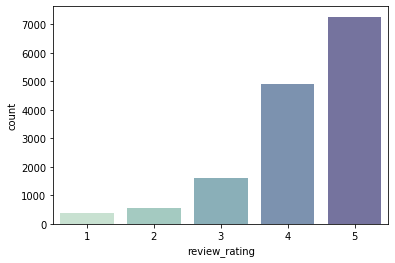

<matplotlib.axes._subplots.AxesSubplot at 0x7f64fb6a1310>

In [0]:
df = es['reviews'].df

col = sns.color_palette("Blues")
sns.countplot(x=df['review_rating'], palette = sns.cubehelix_palette(8, start=1, rot=-.75))

In [0]:
es['reviews'].df = es['reviews'].df.sample(500)

## Step 2. Compare Against Baseline
In order to see how much of an effect these primitives have, we will first create a baseline, and then compare the accuracy of the two models.

In [0]:
rating_df = es['reviews'].df[['index', 'review_rating']]
ignore = {'restaurants': ['rating'],
          'reviews': ['review_rating']}

baseline_feature_matrix, baseline_features = ft.dfs(entityset=es,
                                             target_entity='reviews',
                                             verbose=True,
                                             ignore_variables=ignore)

baseline_fm = baseline_feature_matrix.reindex(rating_df.index)

y = rating_df['review_rating']

baseline_train_fm, baseline_test_fm, baseline_y_train, baseline_y_test = train_test_split(baseline_fm, y, test_size=0.15, stratify=y)

Built 33 features
Elapsed: 00:00 | Progress: 0%| Elapsed: 00:00 | Progress: 47%|████▋ Elapsed: 00:00 | Progress: 100%|██████████Elapsed: 00:00 | Progress: 100%|██████████Elapsed: 00:00 | Progress: 100%|██████████

In [0]:
base_rfc = RandomForestClassifier(n_estimators=100, class_weight = "balanced", n_jobs=-1)
base_rfc.fit(baseline_train_fm, baseline_y_train)
base_rfc.score(baseline_test_fm, baseline_y_test)

Out[10]: 0.5174603174603175

Out[11]:

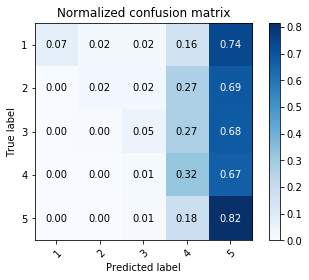

<matplotlib.axes._subplots.AxesSubplot at 0x7f94ef65fe50>

In [0]:
plot_confusion_matrix(baseline_y_test, 
                      base_rfc.predict(baseline_test_fm), 
                      ['1', '2', '3', '4', '5'])

This baseline has an accuracy of about 50%, with most of the samples being classified as a 5, the most common class. This accuracy comes from classifying most reviews as a 4 or a 5, the two most common categories, so it is clear that this model's accuracy only comes from guessing the most common classes and getting it right only due to the frequency of those categories.

## Step 3. Create Feature Matrix
Here we choose the features we wish to include in the training (in this case all of them), and calculate the training feature matrix. We add some transformation primitives, but this dfs will also include many default primitive functions to create features, and setting the `max_depth=4` will ensure that these nlp-primitives create features that other features then stack on.

In [0]:
trans = [DiversityScore,
         LSA,
         MeanCharactersPerWord,
         PartOfSpeechCount,
         PolarityScore, 
         PunctuationCount,
         StopwordCount,
         TitleWordCount,
         UniversalSentenceEncoder,
         UpperCaseCount]

ignore = {'restaurants': ['rating'],
          'reviews': ['review_rating']}

drop_contains = ['(reviews.UNIVERSAL']

features = ft.dfs(entityset=es,
                  target_entity='reviews',
                  trans_primitives=trans,
                  verbose=True,
                  features_only=True,
                  ignore_variables=ignore,
                  drop_contains=drop_contains,
                  max_depth=4)

Built 333 features

This `dfs` call created 333 features, which is about 10 times more features than in the baseline. Now, we will calculate these features.

In [0]:
feature_matrix = ft.calculate_feature_matrix(features=features,
                                             entityset=es,
                                             verbose=True)

Elapsed: 00:00 | Progress: 0%| Elapsed: 00:00 | Progress: 1%| Elapsed: 00:08 | Progress: 1%| Elapsed: 00:09 | Progress: 1%| Elapsed: 00:19 | Progress: 1%| Elapsed: 00:53 | Progress: 1%|▏ Elapsed: 01:02 | Progress: 1%|▏ Elapsed: 01:12 | Progress: 2%|▏ Elapsed: 01:12 | Progress: 2%|▏ Elapsed: 01:30 | Progress: 2%|▏ Elapsed: 01:38 | Progress: 2%|▏ Elapsed: 01:39 | Progress: 2%|▏ Elapsed: 01:39 | Progress: 2%|▏ Elapsed: 01:41 | Progress: 2%|▏ Elapsed: 01:50 | Progress: 2%|▏ Elapsed: 01:54 | Progress: 3%|▎ Elapsed: 02:04 | Progress: 3%|▎ Elapsed: 02:07 | Progress: 3%|▎ Elapsed: 02:14 | Progress: 3%|▎ Elapsed: 02:15 | Progress: 47%|████▋ Elapsed: 02:30 | Progress: 48%|████▊ Elapsed: 02:33 | Progress: 48%|████▊ Elapsed: 02:59 | Progress: 48%|████▊ Elapsed: 03:04 | Progress: 48%|████▊ Elapsed: 03:20 | Progress: 49%|████▉ INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Elapsed: 03:28 | Progress: 49%|████▉ Elapsed: 03:28 | Progress: 49%|████▉ Elapsed: 03:48 | Progress: 49%|████▉ INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Elapsed: 04:05 | Progress: 49%|████▉ Elapsed: 04:07 | Progress: 49%|████▉ Elapsed: 04:17 | Progress: 50%|████▉ Elapsed: 04:24 | Progress: 50%|████▉ Elapsed: 04:34 | Progress: 50%|█████ Elapsed: 05:19 | Progress: 50%|█████ Elapsed: 05:20 | Progress: 51%|█████ Elapsed: 05:21 | Progress: 95%|█████████▌Elapsed: 05:21 | Progress: 100%|██████████Elapsed: 05:21 | Progress: 100%|██████████Elapsed: 05:21 | Progress: 100%|██████████

In [0]:
features[0:50]

Out[14]: [<Feature: restaurant_id>,
 <Feature: DIVERSITY_SCORE(review_text)>,
 <Feature: DIVERSITY_SCORE(review_title)>,
 <Feature: LSA(review_text)>,
 <Feature: LSA(review_title)>,
 <Feature: MEAN_CHARACTERS_PER_WORD(review_text)>,
 <Feature: MEAN_CHARACTERS_PER_WORD(review_title)>,
 <Feature: PART_OF_SPEECH_COUNT(review_text)>,
 <Feature: PART_OF_SPEECH_COUNT(review_title)>,
 <Feature: POLARITY_SCORE(review_text)>,
 <Feature: POLARITY_SCORE(review_title)>,
 <Feature: PUNCTUATION_COUNT(review_text)>,
 <Feature: PUNCTUATION_COUNT(review_title)>,
 <Feature: STOPWORD_COUNT(review_text)>,
 <Feature: STOPWORD_COUNT(review_title)>,
 <Feature: TITLE_WORD_COUNT(review_text)>,
 <Feature: TITLE_WORD_COUNT(review_title)>,
 <Feature: UNIVERSAL_SENTENCE_ENCODER(review_text)>,
 <Feature: UNIVERSAL_SENTENCE_ENCODER(review_title)>,
 <Feature: UPPER_CASE_COUNT(review_text)>,
 <Feature: UPPER_CASE_COUNT(review_title)>,
 <Feature: restaurants.price>,
 <Feature: restaurants.parking>,
 <Feature: restaurants.parking_valet>,
 <Feature: restaurants.parking_garage>,
 <Feature: restaurants.parking_street>,
 <Feature: restaurants.parking_lot>,
 <Feature: restaurants.parking_validated>,
 <Feature: restaurants.parking_free>,
 <Feature: restaurants.smoking>,
 <Feature: restaurants.accessible_wheelchair>,
 <Feature: restaurants.wifi>,
 <Feature: restaurants.meal_breakfast>,
 <Feature: restaurants.meal_deliver>,
 <Feature: restaurants.meal_dinner>,
 <Feature: restaurants.meal_lunch>,
 <Feature: restaurants.meal_takeout>,
 <Feature: restaurants.meal_cater>,
 <Feature: restaurants.options_healthy>,
 <Feature: restaurants.options_organic>,
 <Feature: restaurants.options_vegetarian>,
 <Feature: restaurants.options_vegan>,
 <Feature: restaurants.options_glutenfree>,
 <Feature: restaurants.options_lowfat>,
 <Feature: restaurants.COUNT(reviews)>,
 <Feature: restaurants.MAX(reviews.DIVERSITY_SCORE(review_text))>,
 <Feature: restaurants.MAX(reviews.DIVERSITY_SCORE(review_title))>,
 <Feature: restaurants.MAX(reviews.MEAN_CHARACTERS_PER_WORD(review_text))>,
 <Feature: restaurants.MAX(reviews.MEAN_CHARACTERS_PER_WORD(review_title))>,
 <Feature: restaurants.MAX(reviews.POLARITY_SCORE(review_text))>]

## Step 4. Dividing the data
We must do two things in this step: split the data into a training set and a testing set, and separate the labels from the feature matrix. We will use the train_test_split functionality of sklearn to do this.

In [0]:
feature_matrix = feature_matrix.reindex(rating_df.index)

In [0]:
y = rating_df['review_rating']

train_feature_matrix, test_feature_matrix, y_train, y_test = train_test_split(feature_matrix, y, test_size=0.15, stratify=y)

## Step 5. Machine Learning
Here we create and test various machine learning models from sklearn using the feature matrix.

In [0]:
lgr = LogisticRegression(solver='liblinear', multi_class='auto', max_iter=100)
lgr.fit(train_feature_matrix, y_train)
lgr.score(test_feature_matrix, y_test)

Out[17]: 0.6394557823129252

In [0]:
hgbc = HistGradientBoostingClassifier()
hgbc.fit(train_feature_matrix, y_train)
hgbc.score(test_feature_matrix, y_test)

Out[18]: 0.6884353741496598

In [0]:
rfc = RandomForestClassifier(n_estimators=100, class_weight = "balanced", n_jobs=-1)
rfc.fit(train_feature_matrix, y_train)
rfc.score(test_feature_matrix, y_test)

Out[19]: 0.6421768707482993

Here we can observe the feature importances for this model, and see that the Universal Sentence Encoder features and the polarity score are the most influential in this model.

In [0]:
headers = ["name", "score"]
values = pd.DataFrame(sorted(zip(train_feature_matrix.columns, rfc.feature_importances_), key=lambda x: x[1] * -1))

values.head(10)

Out[20]:

,0,1
0,UNIVERSAL_SENTENCE_ENCODER(review_title)[415],0.015511
1,UNIVERSAL_SENTENCE_ENCODER(review_text)[415],0.011831
2,UNIVERSAL_SENTENCE_ENCODER(review_text)[28],0.010463
3,POLARITY_SCORE(review_text),0.009986
4,UNIVERSAL_SENTENCE_ENCODER(review_text)[289],0.008896
5,POLARITY_SCORE(review_title),0.007442
6,UNIVERSAL_SENTENCE_ENCODER(review_text)[237],0.006792
7,UNIVERSAL_SENTENCE_ENCODER(review_title)[289],0.006208
8,UNIVERSAL_SENTENCE_ENCODER(review_text)[259],0.005780
9,UNIVERSAL_SENTENCE_ENCODER(review_title)[28],0.005718


In [0]:
vot = VotingClassifier(voting='soft', estimators=[('lgr', lgr), ('rfc', rfc), ('hgbc', hgbc)], weights=[3, 1, 6])
vot.fit(train_feature_matrix, y_train)
vot.score(test_feature_matrix, y_test)

Out[21]: 0.6952380952380952

So, we can see that the highest score we can get with a model is around 70%, which might seem like a pretty poor result. However, given that it is a 5 class classification problem, it's not a bad score. Furthermore, by examining the confusion matrix, we can see where the model goes wrong and get a better sense of how far off the model is with its predictions.

Out[22]:

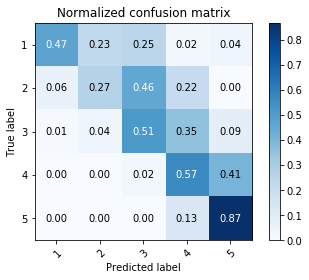

<matplotlib.axes._subplots.AxesSubplot at 0x7f9473f200d0>

In [0]:
plot_confusion_matrix(y_test, 
                      vot.predict(test_feature_matrix), 
                      ['1', '2', '3', '4', '5'])

Out[23]:

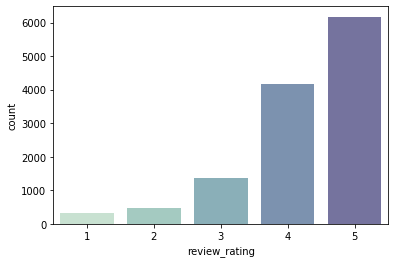

<matplotlib.axes._subplots.AxesSubplot at 0x7f92fb29c750>

In [0]:
sns.countplot(x=y_train, palette = sns.cubehelix_palette(8, start=1, rot=-.75))

Out[24]:

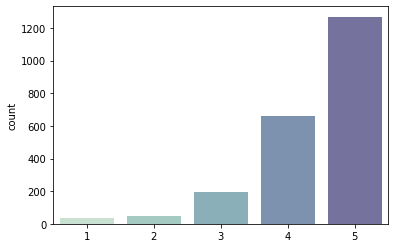

<matplotlib.axes._subplots.AxesSubplot at 0x7f93d86bd7d0>

In [0]:
sns.countplot(x=vot.predict(test_feature_matrix), palette = sns.cubehelix_palette(8, start=1, rot=-.75))

It is clear that the model is pretty accurate, for when it predicts the star rating wrong, it is generally within one star of the correct answer, a vast improvement from the baseline model.

The predictions also have about the same distribution of star ratings as the training data, which suggests that this model is pretty accurate, and doesn't just predict all of the test data to be in the most frequent category. (Unlike the baseline)

When comparing this model with the baseline model, we see an accuracy improvement of almost 40%, which is a huge improvement. Furthermore, when considering the fact that when the model using nlp-primitives is wrong, it is a lot closer to the right answer than the original model, we can see that using these primitives improves the model further beyond the 40% increase in raw accuracy.

## Step 6. Next Steps

This is an end-to-end example of going from raw text data to a machine learning model with Natural Language Processing Primitives. However, in a problem such as this one, ideally there would be more data available, especially pertaining to the customer who wrote each review. 

Featuretools makes it easy to deal with relational datasets, and so this new extra data would be relatively simple to add into the pipeline, just requiring the addition of a new entity to the entityset, and a recalculation of DFS and the following steps with the newly modified entityset.

<p>
    <img src="https://www.featurelabs.com/wp-content/uploads/2017/12/logo.png" alt="Featuretools" />
</p>

Featuretools was created by the developers at [Feature Labs](https://www.featurelabs.com/). If building impactful data science pipelines is important to you or your business, please [get in touch](https://www.featurelabs.com/contact/).

In [0]:
df

Out[6]:

,index,review_text,review_date,restaurant_id,review_title,review_rating
0,0,They have great local craft beers and probably...,2016-03-28,0,Great drinks and food,4
1,1,We went to the downtown SF location. The resta...,2016-03-27,0,Good food &amp; beer,4
2,2,I just came to this place for drinks with an o...,2016-03-16,0,Pretty good beers,4
3,3,"Mediocre food (not bad, just mediocre, you can...",2016-03-08,0,Ridiculously overpriced (yes I live in SF),3
4,4,We headed out for our team dinner to this esta...,2016-03-01,0,Team dinner,4
...,...,...,...,...,...,...
14695,14695,Try the chicken and waffles or the biscuit san...,2012-07-19,146,"Yum, don&#39;t miss it!",5
14696,14696,We have eaten here many times and have always ...,2012-07-11,146,Bad Taste,3
14697,14697,The restaurant is hard to find unless you know...,2012-07-02,146,Hidden gem,5
14698,14698,I stayed at the Farmer's Daughter hotel from A...,2012-06-22,146,"Good food, great atmosphere, even better staff",4


In [0]:
dft5_1 = df[['review_text','review_rating']].rename({'review_text':'input_text','review_rating':'target_text'},axis=1)
dft5_1['prefix'] = ['t5-encode' for x in range(len(dft5_1))]
dft5_1['target_text'] = dft5_1['target_text'].astype(str)
dft5_1

Out[7]:

,input_text,target_text,prefix
0,They have great local craft beers and probably...,4,t5-encode
1,We went to the downtown SF location. The resta...,4,t5-encode
2,I just came to this place for drinks with an o...,4,t5-encode
3,"Mediocre food (not bad, just mediocre, you can...",3,t5-encode
4,We headed out for our team dinner to this esta...,4,t5-encode
...,...,...,...
14695,Try the chicken and waffles or the biscuit san...,5,t5-encode
14696,We have eaten here many times and have always ...,3,t5-encode
14697,The restaurant is hard to find unless you know...,5,t5-encode
14698,I stayed at the Farmer's Daughter hotel from A...,4,t5-encode


In [0]:
dft5_2 = df[['review_title','review_rating']].rename({'review_title':'input_text','review_rating':'target_text'},axis=1)
dft5_2['prefix'] = ['t5-encode' for x in range(len(dft5_2))]
dft5_2['target_text'] = dft5_2['target_text'].astype(str)
dft5_2

Out[8]:

,input_text,target_text,prefix
0,Great drinks and food,4,t5-encode
1,Good food &amp; beer,4,t5-encode
2,Pretty good beers,4,t5-encode
3,Ridiculously overpriced (yes I live in SF),3,t5-encode
4,Team dinner,4,t5-encode
...,...,...,...
14695,"Yum, don&#39;t miss it!",5,t5-encode
14696,Bad Taste,3,t5-encode
14697,Hidden gem,5,t5-encode
14698,"Good food, great atmosphere, even better staff",4,t5-encode


In [0]:
dft5 = pd.concat([dft5_1, dft5_2])
dft5

Out[9]:

,input_text,target_text,prefix
0,They have great local craft beers and probably...,4,t5-encode
1,We went to the downtown SF location. The resta...,4,t5-encode
2,I just came to this place for drinks with an o...,4,t5-encode
3,"Mediocre food (not bad, just mediocre, you can...",3,t5-encode
4,We headed out for our team dinner to this esta...,4,t5-encode
...,...,...,...
14695,"Yum, don&#39;t miss it!",5,t5-encode
14696,Bad Taste,3,t5-encode
14697,Hidden gem,5,t5-encode
14698,"Good food, great atmosphere, even better staff",4,t5-encode


In [0]:
import pandas as pd
from simpletransformers.t5 import T5Model
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

dft5 = shuffle(dft5)
dft5 = shuffle(dft5.sample(frac=.5))
train_df, eval_df = train_test_split(dft5)
train_df

Out[10]:

,input_text,target_text,prefix
12909,Back to your roots with a meal,5,t5-encode
6599,Meh...,3,t5-encode
12131,Excellent French food in My Favorite Alley,5,t5-encode
13387,Beautiful place in a great spot. It is a littl...,5,t5-encode
13377,Nice bayside lunch,4,t5-encode
...,...,...,...
353,great service,5,t5-encode
1237,Incredible food - must have platter!,5,t5-encode
11655,Spent time in the Pig this week as we always d...,5,t5-encode
13704,"Good service, great value, nice atmosphere, we...",4,t5-encode


In [0]:
from simpletransformers.t5 import T5Model

model = T5Model('t5',
                'outputs/best_model/',
                use_cuda=True)

model.args

404 Client Error: Not Found for url: https://huggingface.co/outputs/best_model//resolve/main/config.json

--------------------------------------------------------------------------- 
 HTTPError Traceback (most recent call last)
 /databricks/python/lib/python3.7/site-packages/transformers/configuration_utils.py in get_config_dict (cls, pretrained_model_name_or_path, **kwargs) 
 437 local_files_only = local_files_only , 
 --> 438 use_auth_token = use_auth_token , 
 439 )

 /databricks/python/lib/python3.7/site-packages/transformers/file_utils.py in cached_path (url_or_filename, cache_dir, force_download, proxies, resume_download, user_agent, extract_compressed_file, force_extract, use_auth_token, local_files_only) 
 1141 use_auth_token = use_auth_token , 
 -> 1142 local_files_only = local_files_only , 
 1143 )

 /databricks/python/lib/python3.7/site-packages/transformers/file_utils.py in get_from_cache (url, cache_dir, force_download, proxies, etag_timeout, resume_download, user_agent, use_auth_token, local_files_only) 
 1299 r = requests . head ( url , headers = headers , allow_redirects = False , proxies = proxies , timeout = etag_timeout ) 
 -> 1300 r . raise_for_status ( ) 
 1301 etag = r . headers . get ( "X-Linked-Etag" ) or r . headers . get ( "ETag" ) 

 /databricks/python/lib/python3.7/site-packages/requests/models.py in raise_for_status (self) 
 939 if http_error_msg : 
 --> 940 raise HTTPError ( http_error_msg , response = self ) 
 941 

 HTTPError : 404 Client Error: Not Found for url: https://huggingface.co/outputs/best_model//resolve/main/config.json

During handling of the above exception, another exception occurred:

 OSError Traceback (most recent call last)
 <command-3094418732417175> in <module> 
 3 model = T5Model('t5',
 4 'outputs/best_model/' , 
 ----> 5 use_cuda=True)
 6 
 7 model . args

 /databricks/python/lib/python3.7/site-packages/simpletransformers/t5/t5_model.py in __init__ (self, model_type, model_name, args, tokenizer, use_cuda, cuda_device, **kwargs) 
 118 self . model = model_class ( config = self . config ) 
 119 else : 
 --> 120 self . config = config_class . from_pretrained ( model_name , ** self . args . config ) 
 121 self . model = model_class . from_pretrained ( model_name , config = self . config ) 
 122 

 /databricks/python/lib/python3.7/site-packages/transformers/configuration_utils.py in from_pretrained (cls, pretrained_model_name_or_path, **kwargs) 
 384 
 385 """
 --> 386 config_dict , kwargs = cls . get_config_dict ( pretrained_model_name_or_path , ** kwargs ) 
 387 return cls . from_dict ( config_dict , ** kwargs ) 
 388 

 /databricks/python/lib/python3.7/site-packages/transformers/configuration_utils.py in get_config_dict (cls, pretrained_model_name_or_path, **kwargs) 
 448 f"- or '{pretrained_model_name_or_path}' is the correct path to a directory containing a {CONFIG_NAME} file\n\n" 
 449 )
 --> 450 raise EnvironmentError ( msg ) 
 451 
 452 except json . JSONDecodeError : 

 OSError : Can't load config for 'outputs/best_model/'. Make sure that:

- 'outputs/best_model/' is a correct model identifier listed on 'https://huggingface.co/models'

- or 'outputs/best_model/' is the correct path to a directory containing a config.json file

In [0]:
model_args = {
    "max_seq_length": 196,
    "train_batch_size": 8,
    "eval_batch_size": 8,
    "num_train_epochs": 1,
    "evaluate_during_training": True,
    "evaluate_during_training_steps": 15000,
    "evaluate_during_training_verbose": True,
    "use_multiprocessing": False,
    "fp16": False,
    "save_steps": -1,
    "save_eval_checkpoints": False,
    "save_model_every_epoch": False,
    "reprocess_input_data": True,
    "overwrite_output_dir": True,
    "wandb_project": None,
}

# model = T5Model("t5", "t5-base", args=model_args)

model.train_model(train_df, eval_data=eval_df)

In [0]:
from simpletransformers.t5 import T5Model

model = T5Model('t5',
                '/dbfs/FileStore/tables/outputs/best_model/',
                use_cuda=True)

model.args

Out[12]: T5Args(adafactor_beta1=None, adafactor_clip_threshold=1.0, adafactor_decay_rate=-0.8, adafactor_eps=[1e-30, 0.001], adafactor_relative_step=False, adafactor_scale_parameter=False, adafactor_warmup_init=False, adam_epsilon=1e-08, best_model_dir='outputs/best_model', cache_dir='cache_dir/', config={}, cosine_schedule_num_cycles=0.5, custom_layer_parameters=[], custom_parameter_groups=[], dataloader_num_workers=0, do_lower_case=False, dynamic_quantize=False, early_stopping_consider_epochs=False, early_stopping_delta=0, early_stopping_metric='eval_loss', early_stopping_metric_minimize=True, early_stopping_patience=3, encoding=None, eval_batch_size=8, evaluate_during_training=True, evaluate_during_training_silent=True, evaluate_during_training_steps=15000, evaluate_during_training_verbose=True, evaluate_each_epoch=True, fp16=False, gradient_accumulation_steps=1, learning_rate=0.001, local_rank=-1, logging_steps=50, manual_seed=None, max_grad_norm=1.0, max_seq_length=196, model_name='/dbfs/FileStore/tables/outputs/best_model/', model_type='t5', multiprocessing_chunksize=-1, n_gpu=1, no_cache=False, no_save=False, not_saved_args=[], num_train_epochs=1, optimizer='Adafactor', output_dir='outputs/', overwrite_output_dir=True, polynomial_decay_schedule_lr_end=1e-07, polynomial_decay_schedule_power=1.0, process_count=10, quantized_model=False, reprocess_input_data=True, save_best_model=True, save_eval_checkpoints=False, save_model_every_epoch=False, save_optimizer_and_scheduler=True, save_steps=-1, scheduler='constant_schedule_with_warmup', silent=False, skip_special_tokens=True, tensorboard_dir=None, thread_count=None, tokenizer_name=None, tokenizer_type=None, train_batch_size=8, train_custom_parameters_only=False, use_cached_eval_features=False, use_early_stopping=False, use_hf_datasets=False, use_multiprocessing=False, use_multiprocessing_for_evaluation=True, wandb_kwargs={}, wandb_project=None, warmup_ratio=0.06, warmup_steps=83, weight_decay=0.0, model_class='T5Model', dataset_class=None, do_sample=False, early_stopping=True, evaluate_generated_text=False, length_penalty=2.0, max_length=20, max_steps=-1, num_beams=1, num_return_sequences=1, preprocess_inputs=True, repetition_penalty=1.0, special_tokens_list=[], top_k=None, top_p=None, use_multiprocessed_decoding=True)

In [0]:
model_pretuned_sentiment = T5Model('t5',
                                   'mrm8488/t5-base-finetuned-imdb-sentiment',
                                   use_cuda=True)
model_pretuned_sentiment.args

Downloading: 0%| | 0.00/1.21k [00:00<?, ?B/s]Downloading: 100%|██████████| 1.21k/1.21k [00:00<00:00, 670kB/s]
Downloading: 0%| | 0.00/892M [00:00<?, ?B/s]Downloading: 1%| | 4.46M/892M [00:00<00:19, 44.6MB/s]Downloading: 1%| | 8.92M/892M [00:00<00:30, 28.6MB/s]Downloading: 2%|▏ | 13.6M/892M [00:00<00:25, 35.0MB/s]Downloading: 2%|▏ | 18.2M/892M [00:00<00:22, 38.8MB/s]Downloading: 3%|▎ | 22.8M/892M [00:00<00:21, 41.0MB/s]Downloading: 3%|▎ | 27.4M/892M [00:00<00:33, 26.0MB/s]Downloading: 4%|▎ | 31.3M/892M [00:00<00:29, 29.0MB/s]Downloading: 4%|▍ | 36.4M/892M [00:01<00:25, 34.0MB/s]Downloading: 5%|▍ | 41.1M/892M [00:01<00:22, 37.4MB/s]Downloading: 5%|▌ | 46.2M/892M [00:01<00:20, 41.0MB/s]Downloading: 6%|▌ | 50.7M/892M [00:01<00:22, 37.9MB/s]Downloading: 6%|▌ | 55.5M/892M [00:01<00:20, 40.5MB/s]Downloading: 7%|▋ | 60.3M/892M [00:01<00:19, 42.7MB/s]Downloading: 7%|▋ | 65.2M/892M [00:01<00:18, 44.5MB/s]Downloading: 8%|▊ | 70.3M/892M [00:01<00:17, 46.3MB/s]Downloading: 8%|▊ | 75.4M/892M [00:01<00:17, 47.5MB/s]Downloading: 9%|▉ | 80.2M/892M [00:02<00:19, 40.6MB/s]Downloading: 9%|▉ | 84.5M/892M [00:02<00:20, 39.0MB/s]Downloading: 10%|█ | 89.4M/892M [00:02<00:19, 41.4MB/s]Downloading: 11%|█ | 93.7M/892M [00:02<00:22, 35.6MB/s]Downloading: 11%|█ | 98.5M/892M [00:02<00:20, 38.8MB/s]Downloading: 12%|█▏ | 104M/892M [00:02<00:18, 41.8MB/s] Downloading: 12%|█▏ | 108M/892M [00:02<00:18, 42.5MB/s]Downloading: 13%|█▎ | 112M/892M [00:02<00:21, 36.4MB/s]Downloading: 13%|█▎ | 117M/892M [00:03<00:19, 39.3MB/s]Downloading: 14%|█▎ | 122M/892M [00:03<00:18, 40.9MB/s]Downloading: 14%|█▍ | 126M/892M [00:03<00:18, 42.4MB/s]Downloading: 15%|█▍ | 131M/892M [00:03<00:17, 43.6MB/s]Downloading: 15%|█▌ | 136M/892M [00:03<00:17, 44.0MB/s]Downloading: 16%|█▌ | 140M/892M [00:03<00:16, 44.7MB/s]Downloading: 16%|█▌ | 145M/892M [00:03<00:16, 44.9MB/s]Downloading: 17%|█▋ | 149M/892M [00:03<00:16, 45.3MB/s]Downloading: 17%|█▋ | 155M/892M [00:03<00:15, 47.4MB/s]Downloading: 18%|█▊ | 160M/892M [00:03<00:14, 49.1MB/s]Downloading: 19%|█▊ | 165M/892M [00:04<00:14, 50.8MB/s]Downloading: 19%|█▉ | 171M/892M [00:04<00:13, 51.9MB/s]Downloading: 20%|█▉ | 176M/892M [00:04<00:13, 52.8MB/s]Downloading: 20%|██ | 182M/892M [00:04<00:13, 53.2MB/s]Downloading: 21%|██ | 187M/892M [00:04<00:13, 53.3MB/s]Downloading: 22%|██▏ | 193M/892M [00:04<00:12, 53.8MB/s]Downloading: 22%|██▏ | 198M/892M [00:04<00:16, 43.0MB/s]Downloading: 23%|██▎ | 203M/892M [00:04<00:17, 40.2MB/s]Downloading: 23%|██▎ | 208M/892M [00:04<00:15, 43.5MB/s]Downloading: 24%|██▍ | 213M/892M [00:05<00:14, 46.0MB/s]Downloading: 25%|██▍ | 219M/892M [00:05<00:13, 48.2MB/s]Downloading: 25%|██▌ | 224M/892M [00:05<00:13, 50.2MB/s]Downloading: 26%|██▌ | 230M/892M [00:05<00:12, 51.5MB/s]Downloading: 26%|██▋ | 235M/892M [00:05<00:12, 52.3MB/s]Downloading: 27%|██▋ | 240M/892M [00:05<00:12, 52.8MB/s]Downloading: 28%|██▊ | 246M/892M [00:05<00:12, 53.2MB/s]Downloading: 28%|██▊ | 251M/892M [00:05<00:11, 53.9MB/s]Downloading: 29%|██▉ | 257M/892M [00:05<00:11, 54.3MB/s]Downloading: 29%|██▉ | 262M/892M [00:05<00:11, 54.2MB/s]Downloading: 30%|███ | 268M/892M [00:06<00:11, 54.6MB/s]Downloading: 31%|███ | 273M/892M [00:06<00:12, 50.4MB/s]Downloading: 31%|███ | 279M/892M [00:06<00:12, 50.6MB/s]Downloading: 32%|███▏ | 284M/892M [00:06<00:14, 42.9MB/s]Downloading: 32%|███▏ | 288M/892M [00:06<00:15, 38.3MB/s]Downloading: 33%|███▎ | 293M/892M [00:06<00:14, 40.8MB/s]Downloading: 33%|███▎ | 298M/892M [00:06<00:13, 43.0MB/s]Downloading: 34%|███▍ | 302M/892M [00:06<00:13, 43.2MB/s]Downloading: 34%|███▍ | 307M/892M [00:07<00:13, 44.4MB/s]Downloading: 35%|███▌ | 312M/892M [00:07<00:12, 46.1MB/s]Downloading: 36%|███▌ | 317M/892M [00:07<00:12, 46.6MB/s]Downloading: 36%|███▌ | 322M/892M [00:07<00:12, 45.6MB/s]Downloading: 37%|███▋ | 326M/892M [00:07<00:12, 45.7MB/s]Downloading: 37%|███▋ | 331M/892M [00:07<00:12, 45.5MB/s]Downloading: 38%|███▊ | 336M/892M [00:07<00:12, 45.7MB/s]Downloading: 

In [0]:
t = ['Great drinks and food', 
     'Good food &amp; beer', 
     'Pretty good beers']

list(np.array(model.predict(t)).astype(float))

Generating outputs: 0%| | 0/1 [00:00<?, ?it/s]Generating outputs: 100%|██████████| 1/1 [00:00<00:00, 3.17it/s]Generating outputs: 100%|██████████| 1/1 [00:00<00:00, 3.16it/s]
Decoding outputs: 0%| | 0/3 [00:00<?, ?it/s]Decoding outputs: 33%|███▎ | 1/3 [00:00<00:01, 1.14it/s]Decoding outputs: 100%|██████████| 3/3 [00:00<00:00, 3.43it/s]
Out[14]: [4.0, 4.0, 4.0]

In [0]:
list(np.where(np.array(model_pretuned_sentiment.predict(t))=='positive',1.0,0.0))

Generating outputs: 0%| | 0/1 [00:00<?, ?it/s]Generating outputs: 100%|██████████| 1/1 [00:00<00:00, 7.57it/s]Generating outputs: 100%|██████████| 1/1 [00:00<00:00, 7.56it/s]
Decoding outputs: 0%| | 0/3 [00:00<?, ?it/s]Decoding outputs: 33%|███▎ | 1/3 [00:00<00:01, 1.17it/s]Decoding outputs: 100%|██████████| 3/3 [00:00<00:00, 3.50it/s]
Out[15]: [1.0, 1.0, 1.0]

In [0]:
import numpy as np
from featuretools.primitives.base import TransformPrimitive
from featuretools.variable_types import Numeric, Text


class T5Encoder(TransformPrimitive):
    """Determines the number of title words in a string.

    Description:
        Given list of strings, determine the number of title words
        in each string. A title word is defined as any word starting
        with a capital letter. Words at the start of a sentence will
        be counted.

        If a string is missing, return `NaN`.

    Examples:
        >>> x = ['My favorite movie is Jaws.', 'this is a string', 'AAA']
        >>> title_word_count = TitleWordCount()
        >>> title_word_count(x).tolist()
        [2.0, 0.0, 1.0]
    """
    name = "t5_encoder"
    input_types = [Text]
    return_type = Numeric
    default_value = 0
    
    def __init__(self, model=model):
      self.model = model

    def get_function(self):

        def t5_encoder(x):
            model.args.use_multiprocessing = True
            return list(np.array(model.predict(x.tolist())).astype(float))
        return t5_encoder


In [0]:

class T5SentimentEncoder(TransformPrimitive):
    """Determines the number of title words in a string.

    Description:
        Given list of strings, determine the number of title words
        in each string. A title word is defined as any word starting
        with a capital letter. Words at the start of a sentence will
        be counted.

        If a string is missing, return `NaN`.

    Examples:
        >>> x = ['My favorite movie is Jaws.', 'this is a string', 'AAA']
        >>> title_word_count = TitleWordCount()
        >>> title_word_count(x).tolist()
        [2.0, 0.0, 1.0]
    """
    name = "t5_sentiment_encoder"
    input_types = [Text]
    return_type = Numeric
    default_value = 0
    
    def __init__(self, model=model_pretuned_sentiment):
      self.model = model

    def get_function(self):

        def t5_sentiment_encoder(x):
            model.args.use_multiprocessing = True
            return list(np.where(np.array(model_pretuned_sentiment.predict(x.tolist()))=='positive',1.0,0.0))
        return t5_sentiment_encoder

In [0]:
trans = [
           T5Encoder,
           T5SentimentEncoder,
           DiversityScore,
           LSA,
           MeanCharactersPerWord,
           PartOfSpeechCount,
           PolarityScore, 
           PunctuationCount,
           StopwordCount,
           TitleWordCount,
           UniversalSentenceEncoder,
           UpperCaseCount
        ]

ignore = {'restaurants': ['rating'],
          'reviews': ['review_rating']}

drop_contains = ['(reviews.UNIVERSAL']

features = ft.dfs(entityset=es,
                  target_entity='reviews',
                  trans_primitives=trans,
                  verbose=True,
                  features_only=True,
                  ignore_variables=ignore,
                  drop_contains=drop_contains,
                  max_depth=4)

INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/2'.
INFO:absl:Downloaded https://tfhub.dev/google/universal-sentence-encoder/2, Total size: 993.27MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/2'.
Built 347 features

In [0]:
# es['reviews'].df = es['reviews'].df.sample(20)
# es

In [0]:
feature_matrix = ft.calculate_feature_matrix(features=features,
                                             entityset=es,
                                             verbose=True)

Elapsed: 00:00 | Progress: 0%| Elapsed: 00:00 | Progress: 1%| Elapsed: 00:08 | Progress: 1%| Elapsed: 00:09 | Progress: 1%| Elapsed: 00:20 | Progress: 1%| Elapsed: 00:56 | Progress: 1%| Elapsed: 01:04 | Progress: 1%|▏ Elapsed: 01:14 | Progress: 2%|▏ Elapsed: 01:14 | Progress: 2%|▏ 
Generating outputs: 0%| | 0/1838 [00:00<?, ?it/s]
Generating outputs: 0%| | 1/1838 [00:00<11:00, 2.78it/s]
Generating outputs: 0%| | 2/1838 [00:00<09:57, 3.07it/s]
Generating outputs: 0%| | 3/1838 [00:00<09:20, 3.28it/s]
Generating outputs: 0%| | 4/1838 [00:01<08:56, 3.42it/s]
Generating outputs: 0%| | 5/1838 [00:01<08:55, 3.42it/s]
Generating outputs: 0%| | 6/1838 [00:01<08:45, 3.49it/s]
Generating outputs: 0%| | 7/1838 [00:02<08:35, 3.55it/s]
Generating outputs: 0%| | 8/1838 [00:02<08:29, 3.59it/s]
Generating outputs: 0%| | 9/1838 [00:02<08:27, 3.60it/s]
Generating outputs: 1%| | 10/1838 [00:02<08:23, 3.63it/s]
Generating outputs: 1%| | 11/1838 [00:03<08:22, 3.63it/s]
Generating outputs: 1%| | 12/1838 [00:03<08:21, 3.64it/s]
Generating outputs: 1%| | 13/1838 [00:03<08:20, 3.65it/s]
Generating outputs: 1%| | 14/1838 [00:03<08:20, 3.64it/s]
Generating outputs: 1%| | 15/1838 [00:04<08:18, 3.66it/s]
Generating outputs: 1%| | 16/1838 [00:04<08:19, 3.64it/s]
Generating outputs: 1%| | 17/1838 [00:04<08:17, 3.66it/s]
Generating outputs: 1%| | 18/1838 [00:05<08:18, 3.65it/s]
Generating outputs: 1%| | 19/1838 [00:05<08:20, 3.63it/s]
Generating outputs: 1%| | 20/1838 [00:05<08:17, 3.65it/s]
Generating outputs: 1%| | 21/1838 [00:05<08:18, 3.64it/s]
Generating outputs: 1%| | 22/1838 [00:06<08:18, 3.64it/s]
Generating outputs: 1%|▏ | 23/1838 [00:06<08:17, 3.65it/s]
Generating outputs: 1%|▏ | 24/1838 [00:06<08:18, 3.64it/s]
Generating outputs: 1%|▏ | 25/1838 [00:06<08:16, 3.65it/s]
Generating outputs: 1%|▏ | 26/1838 [00:07<08:17, 3.64it/s]
Generating outputs: 1%|▏ | 27/1838 [00:07<08:15, 3.65it/s]
Generating outputs: 2%|▏ | 28/1838 [00:07<08:16, 3.65it/s]
Generating outputs: 2%|▏ | 29/1838 [00:08<08:15, 3.65it/s]
Generating outputs: 2%|▏ | 30/1838 [00:08<08:15, 3.65it/s]
Generating outputs: 2%|▏ | 31/1838 [00:08<08:17, 3.63it/s]
Generating outputs: 2%|▏ | 32/1838 [00:08<08:29, 3.55it/s]
Generating outputs: 2%|▏ | 33/1838 [00:09<08:22, 3.59it/s]
Generating outputs: 2%|▏ | 34/1838 [00:09<08:19, 3.61it/s]
Generating outputs: 2%|▏ | 35/1838 [00:09<08:21, 3.59it/s]
Generating outputs: 2%|▏ | 36/1838 [00:10<08:17, 3.62it/s]
Generating outputs: 2%|▏ | 37/1838 [00:10<08:15, 3.63it/s]
Generating outputs: 2%|▏ | 38/1838 [00:10<08:12, 3.65it/s]
Generating outputs: 2%|▏ | 39/1838 [00:10<08:11, 3.66it/s]
Generating outputs: 2%|▏ | 40/1838 [00:11<08:10, 3.67it/s]
Generating outputs: 2%|▏ | 41/1838 [00:11<08:12, 3.65it/s]Elapsed: 01:26 | Progress: 2%|▏ 
Generating outputs: 2%|▏ | 42/1838 [00:11<08:14, 3.63it/s]
Generating outputs: 2%|▏ | 43/1838 [00:11<08:13, 3.64it/s]
Generating outputs: 2%|▏ | 44/1838 [00:12<08:17, 3.61it/s]
Generating outputs: 2%|▏ | 45/1838 [00:12<08:15, 3.62it/s]
Generating outputs: 3%|▎ | 46/1838 [00:12<08:11, 3.65it/s]
Generating outputs: 3%|▎ | 47/1838 [00:13<08:10, 3.65it/s]
Generating outputs: 3%|▎ | 48/1838 [00:13<08:10, 3.65it/s]
Generating outputs: 3%|▎ | 49/1838 [00:13<08:08, 3.66it/s]
Generating outputs: 3%|▎ | 50/1838 [00:13<08:09, 3.65it/s]
Generating outputs: 3%|▎ | 51/1838 [00:14<08:07, 3.66it/s]
Generating outputs: 3%|▎ | 52/1838 [00:14<08:06, 3.67it/s]
Generating outputs: 3%|▎ | 53/1838 [00:14<08:11, 3.63it/s]
Generating outputs: 3%|▎ | 54/1838 [00:14<08:10, 3.64it/s]
Generating outputs: 3%|▎ | 55/1838 [00:15<08:09, 3.64it/s]
Generating outputs: 3%|▎ | 56/1838 [00:15<08:07, 3.65it/s]
Generating outputs: 3%|▎ | 57/1838 [00:15<08:09, 3.64it/s]
Generating outputs: 3%|▎ | 58/1838 [00:16<08:08, 3.64it/s]
Generating outputs: 3%|▎ | 59/1838 [00:16<08:09, 3.63it/s]
Generating outputs: 3%|▎ | 60/1838 [00:16<08:11, 3.62it/s]
Generating outputs: 3%|▎ | 61/1838 [00:16<08:08, 3.63it

In [0]:
features

Out[20]: [<Feature: restaurant_id>,
 <Feature: DIVERSITY_SCORE(review_text)>,
 <Feature: DIVERSITY_SCORE(review_title)>,
 <Feature: LSA(review_text)>,
 <Feature: LSA(review_title)>,
 <Feature: MEAN_CHARACTERS_PER_WORD(review_text)>,
 <Feature: MEAN_CHARACTERS_PER_WORD(review_title)>,
 <Feature: PART_OF_SPEECH_COUNT(review_text)>,
 <Feature: PART_OF_SPEECH_COUNT(review_title)>,
 <Feature: POLARITY_SCORE(review_text)>,
 <Feature: POLARITY_SCORE(review_title)>,
 <Feature: PUNCTUATION_COUNT(review_text)>,
 <Feature: PUNCTUATION_COUNT(review_title)>,
 <Feature: STOPWORD_COUNT(review_text)>,
 <Feature: STOPWORD_COUNT(review_title)>,
 <Feature: T5_ENCODER(review_title)>,
 <Feature: T5_SENTIMENT_ENCODER(review_title)>,
 <Feature: TITLE_WORD_COUNT(review_text)>,
 <Feature: TITLE_WORD_COUNT(review_title)>,
 <Feature: UNIVERSAL_SENTENCE_ENCODER(review_text)>,
 <Feature: UNIVERSAL_SENTENCE_ENCODER(review_title)>,
 <Feature: UPPER_CASE_COUNT(review_text)>,
 <Feature: UPPER_CASE_COUNT(review_title)>,
 <Feature: restaurants.price>,
 <Feature: restaurants.parking>,
 <Feature: restaurants.parking_valet>,
 <Feature: restaurants.parking_garage>,
 <Feature: restaurants.parking_street>,
 <Feature: restaurants.parking_lot>,
 <Feature: restaurants.parking_validated>,
 <Feature: restaurants.parking_free>,
 <Feature: restaurants.smoking>,
 <Feature: restaurants.accessible_wheelchair>,
 <Feature: restaurants.wifi>,
 <Feature: restaurants.meal_breakfast>,
 <Feature: restaurants.meal_deliver>,
 <Feature: restaurants.meal_dinner>,
 <Feature: restaurants.meal_lunch>,
 <Feature: restaurants.meal_takeout>,
 <Feature: restaurants.meal_cater>,
 <Feature: restaurants.options_healthy>,
 <Feature: restaurants.options_organic>,
 <Feature: restaurants.options_vegetarian>,
 <Feature: restaurants.options_vegan>,
 <Feature: restaurants.options_glutenfree>,
 <Feature: restaurants.options_lowfat>,
 <Feature: restaurants.COUNT(reviews)>,
 <Feature: restaurants.MAX(reviews.DIVERSITY_SCORE(review_text))>,
 <Feature: restaurants.MAX(reviews.DIVERSITY_SCORE(review_title))>,
 <Feature: restaurants.MAX(reviews.MEAN_CHARACTERS_PER_WORD(review_text))>,
 <Feature: restaurants.MAX(reviews.MEAN_CHARACTERS_PER_WORD(review_title))>,
 <Feature: restaurants.MAX(reviews.POLARITY_SCORE(review_text))>,
 <Feature: restaurants.MAX(reviews.POLARITY_SCORE(review_title))>,
 <Feature: restaurants.MAX(reviews.PUNCTUATION_COUNT(review_text))>,
 <Feature: restaurants.MAX(reviews.PUNCTUATION_COUNT(review_title))>,
 <Feature: restaurants.MAX(reviews.STOPWORD_COUNT(review_text))>,
 <Feature: restaurants.MAX(reviews.STOPWORD_COUNT(review_title))>,
 <Feature: restaurants.MAX(reviews.T5_ENCODER(review_title))>,
 <Feature: restaurants.MAX(reviews.T5_SENTIMENT_ENCODER(review_title))>,
 <Feature: restaurants.MAX(reviews.TITLE_WORD_COUNT(review_text))>,
 <Feature: restaurants.MAX(reviews.TITLE_WORD_COUNT(review_title))>,
 <Feature: restaurants.MAX(reviews.UPPER_CASE_COUNT(review_text))>,
 <Feature: restaurants.MAX(reviews.UPPER_CASE_COUNT(review_title))>,
 <Feature: restaurants.MEAN(reviews.DIVERSITY_SCORE(review_text))>,
 <Feature: restaurants.MEAN(reviews.DIVERSITY_SCORE(review_title))>,
 <Feature: restaurants.MEAN(reviews.MEAN_CHARACTERS_PER_WORD(review_text))>,
 <Feature: restaurants.MEAN(reviews.MEAN_CHARACTERS_PER_WORD(review_title))>,
 <Feature: restaurants.MEAN(reviews.POLARITY_SCORE(review_text))>,
 <Feature: restaurants.MEAN(reviews.POLARITY_SCORE(review_title))>,
 <Feature: restaurants.MEAN(reviews.PUNCTUATION_COUNT(review_text))>,
 <Feature: restaurants.MEAN(reviews.PUNCTUATION_COUNT(review_title))>,
 <Feature: restaurants.MEAN(reviews.STOPWORD_COUNT(review_text))>,
 <Feature: restaurants.MEAN(reviews.STOPWORD_COUNT(review_title))>,
 <Feature: restaurants.MEAN(reviews.T5_ENCODER(review_title))>,
 <Feature: restaurants.MEAN(reviews.T5_SENTIMENT_ENCODER(review_title))>,
 <Feature: restaurants.MEAN(reviews.TITLE_WORD_COUNT(review_text))>,
 <Feature: restaurants.MEAN(reviews.TITLE_WORD_COUNT(review_

In [0]:
feature_matrix = feature_matrix.reindex(rating_df.index)

In [0]:
feature_matrix.to_csv('/dbfs/FileStore/tables/feature_matrix.csv')
feature_matrix

Out[25]:

,restaurant_id,DIVERSITY_SCORE(review_text),DIVERSITY_SCORE(review_title),LSA(review_text)[0],LSA(review_text)[1],LSA(review_title)[0],LSA(review_title)[1],MEAN_CHARACTERS_PER_WORD(review_text),MEAN_CHARACTERS_PER_WORD(review_title),PART_OF_SPEECH_COUNT(review_text)[0],PART_OF_SPEECH_COUNT(review_text)[1],PART_OF_SPEECH_COUNT(review_text)[2],PART_OF_SPEECH_COUNT(review_text)[3],PART_OF_SPEECH_COUNT(review_text)[4],PART_OF_SPEECH_COUNT(review_text)[5],PART_OF_SPEECH_COUNT(review_text)[6],PART_OF_SPEECH_COUNT(review_text)[7],PART_OF_SPEECH_COUNT(review_text)[8],PART_OF_SPEECH_COUNT(review_text)[9],PART_OF_SPEECH_COUNT(review_text)[10],PART_OF_SPEECH_COUNT(review_text)[11],PART_OF_SPEECH_COUNT(review_text)[12],PART_OF_SPEECH_COUNT(review_text)[13],PART_OF_SPEECH_COUNT(review_text)[14],PART_OF_SPEECH_COUNT(review_title)[0],PART_OF_SPEECH_COUNT(review_title)[1],PART_OF_SPEECH_COUNT(review_title)[2],PART_OF_SPEECH_COUNT(review_title)[3],PART_OF_SPEECH_COUNT(review_title)[4],PART_OF_SPEECH_COUNT(review_title)[5],PART_OF_SPEECH_COUNT(review_title)[6],PART_OF_SPEECH_COUNT(review_title)[7],PART_OF_SPEECH_COUNT(review_title)[8],PART_OF_SPEECH_COUNT(review_title)[9],PART_OF_SPEECH_COUNT(review_title)[10],PART_OF_SPEECH_COUNT(review_title)[11],PART_OF_SPEECH_COUNT(review_title)[12],PART_OF_SPEECH_COUNT(review_title)[13],PART_OF_SPEECH_COUNT(review_title)[14],POLARITY_SCORE(review_text),...,restaurants.STD(reviews.PART_OF_SPEECH_COUNT(review_title)[4]),restaurants.STD(reviews.PART_OF_SPEECH_COUNT(review_title)[5]),restaurants.STD(reviews.PART_OF_SPEECH_COUNT(review_title)[6]),restaurants.STD(reviews.PART_OF_SPEECH_COUNT(review_title)[7]),restaurants.STD(reviews.PART_OF_SPEECH_COUNT(review_title)[8]),restaurants.STD(reviews.PART_OF_SPEECH_COUNT(review_title)[9]),restaurants.SUM(reviews.LSA(review_text)[0]),restaurants.SUM(reviews.LSA(review_text)[1]),restaurants.SUM(reviews.LSA(review_title)[0]),restaurants.SUM(reviews.LSA(review_title)[1]),restaurants.SUM(reviews.PART_OF_SPEECH_COUNT(review_text)[0]),restaurants.SUM(reviews.PART_OF_SPEECH_COUNT(review_text)[10]),restaurants.SUM(reviews.PART_OF_SPEECH_COUNT(review_text)[11]),restaurants.SUM(reviews.PART_OF_SPEECH_COUNT(review_text)[12]),restaurants.SUM(reviews.PART_OF_SPEECH_COUNT(review_text)[13]),restaurants.SUM(reviews.PART_OF_SPEECH_COUNT(review_text)[14]),restaurants.SUM(reviews.PART_OF_SPEECH_COUNT(review_text)[1]),restaurants.SUM(reviews.PART_OF_SPEECH_COUNT(review_text)[2]),restaurants.SUM(reviews.PART_OF_SPEECH_COUNT(review_text)[3]),restaurants.SUM(reviews.PART_OF_SPEECH_COUNT(review_text)[4]),restaurants.SUM(reviews.PART_OF_SPEECH_COUNT(review_text)[5]),restaurants.SUM(reviews.PART_OF_SPEECH_COUNT(review_text)[6]),restaurants.SUM(reviews.PART_OF_SPEECH_COUNT(review_text)[7]),restaurants.SUM(reviews.PART_OF_SPEECH_COUNT(review_text)[8]),restaurants.SUM(reviews.PART_OF_SPEECH_COUNT(review_text)[9]),restaurants.SUM(reviews.PART_OF_SPEECH_COUNT(review_title)[0]),restaurants.SUM(reviews.PART_OF_SPEECH_COUNT(review_title)[10]),restaurants.SUM(reviews.PART_OF_SPEECH_COUNT(review_title)[11]),restaurants.SUM(reviews.PART_OF_SPEECH_COUNT(review_title)[12]),restaurants.SUM(reviews.PART_OF_SPEECH_COUNT(review_title)[13]),restaurants.SUM(reviews.PART_OF_SPEECH_COUNT(review_title)[14]),restaurants.SUM(reviews.PART_OF_SPEECH_COUNT(review_title)[1]),restaurants.SUM(reviews.PART_OF_SPEECH_COUNT(review_title)[2]),restaurants.SUM(reviews.PART_OF_SPEECH_COUNT(review_title)[3]),restaurants.SUM(reviews.PART_OF_SPEECH_COUNT(review_title)[4]),restaurants.SUM(reviews.PART_OF_SPEECH_COUNT(review_title)[5]),restaurants.SUM(reviews.PART_OF_SPEECH_COUNT(review_title)[6]),restaurants.SUM(reviews.PART_OF_SPEECH_COUNT(review_title)[7]),restaurants.SUM(reviews.PART_OF_SPEECH_COUNT(review_title)[8]),restaurants.SUM(reviews.PART_OF_SPEECH_COUNT(review_title)[9])
0,0,0.928571,1.0,0.041056,0.013206,0.016110,0.000714,3.814815,4.500000,1.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,14.0,1.0,3.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0

In [0]:
y = rating_df['review_rating']

train_feature_matrix, test_feature_matrix, y_train, y_test = train_test_split(feature_matrix, y, test_size=0.15, stratify=y)

In [0]:
lgr = LogisticRegression(solver='liblinear', multi_class='auto', max_iter=100)
lgr.fit(train_feature_matrix, y_train)
lgr.score(test_feature_matrix, y_test)

Out[27]: 0.6421768707482993

In [0]:
hgbc = HistGradientBoostingClassifier()
hgbc.fit(train_feature_matrix, y_train)
hgbc.score(test_feature_matrix, y_test)

Out[28]: 0.6807256235827664

In [0]:
rfc = RandomForestClassifier(n_estimators=100, class_weight = "balanced", n_jobs=-1)
rfc.fit(train_feature_matrix, y_train)
rfc.score(test_feature_matrix, y_test)

Out[29]: 0.6535147392290249

In [0]:
headers = ["name", "score"]
values = pd.DataFrame(sorted(zip(train_feature_matrix.columns, rfc.feature_importances_), key=lambda x: x[1] * -1))

values.head(10)

Out[30]:

,0,1
0,T5_SENTIMENT_ENCODER(review_title),0.013718
1,UNIVERSAL_SENTENCE_ENCODER(review_text)[415],0.012710
2,UNIVERSAL_SENTENCE_ENCODER(review_text)[28],0.012192
3,POLARITY_SCORE(review_text),0.011586
4,UNIVERSAL_SENTENCE_ENCODER(review_title)[415],0.011579
5,UNIVERSAL_SENTENCE_ENCODER(review_text)[237],0.008201
6,POLARITY_SCORE(review_title),0.008028
7,UNIVERSAL_SENTENCE_ENCODER(review_text)[289],0.006696
8,UNIVERSAL_SENTENCE_ENCODER(review_title)[28],0.006162
9,UNIVERSAL_SENTENCE_ENCODER(review_title)[348],0.006059


In [0]:
vot = VotingClassifier(voting='soft', estimators=[('lgr', lgr), ('rfc', rfc), ('hgbc', hgbc)], weights=[3, 1, 6])
vot.fit(train_feature_matrix, y_train)
vot.score(test_feature_matrix, y_test)

Out[31]: 0.6952380952380952

Out[32]:

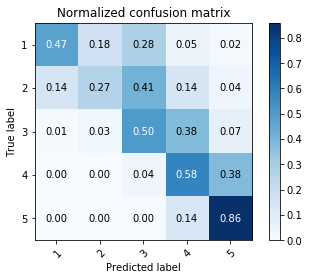

<matplotlib.axes._subplots.AxesSubplot at 0x7f64476fead0>

In [0]:
plot_confusion_matrix(y_test, 
                      vot.predict(test_feature_matrix), 
                      ['1', '2', '3', '4', '5'])

Out[33]:

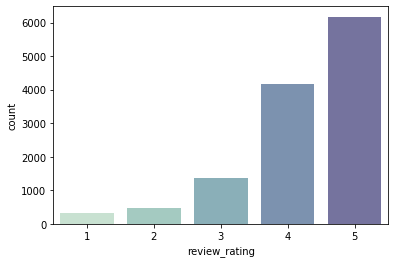

<matplotlib.axes._subplots.AxesSubplot at 0x7f644813a6d0>

In [0]:
sns.countplot(x=y_train, palette = sns.cubehelix_palette(8, start=1, rot=-.75))

Out[34]:

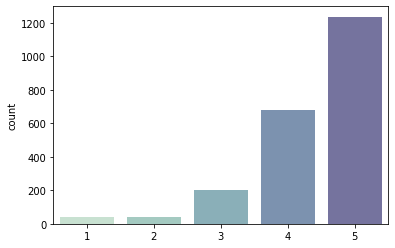

<matplotlib.axes._subplots.AxesSubplot at 0x7f642c0a8e90>

In [0]:
sns.countplot(x=vot.predict(test_feature_matrix), palette = sns.cubehelix_palette(8, start=1, rot=-.75))

Out[41]:

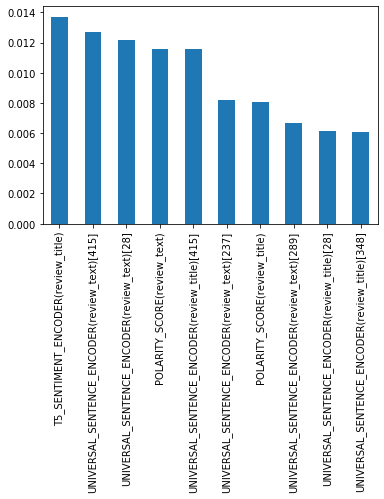

<matplotlib.axes._subplots.AxesSubplot at 0x7f63847a0310>

In [0]:
feat_importances = pd.Series(rfc.feature_importances_, index=train_feature_matrix.columns)
feat_importances.nlargest(10).plot(kind='bar')

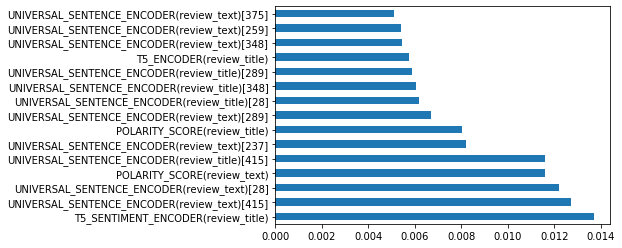

In [0]:
ax = feat_importances.nlargest(15).plot(kind='barh')
ax.figure.savefig('/dbfs/FileStore/t5blog_feature_importance.png')

In [0]:
values.head(15)

Out[43]:

,0,1
0,T5_SENTIMENT_ENCODER(review_title),0.013718
1,UNIVERSAL_SENTENCE_ENCODER(review_text)[415],0.012710
2,UNIVERSAL_SENTENCE_ENCODER(review_text)[28],0.012192
3,POLARITY_SCORE(review_text),0.011586
4,UNIVERSAL_SENTENCE_ENCODER(review_title)[415],0.011579
5,UNIVERSAL_SENTENCE_ENCODER(review_text)[237],0.008201
6,POLARITY_SCORE(review_title),0.008028
7,UNIVERSAL_SENTENCE_ENCODER(review_text)[289],0.006696
8,UNIVERSAL_SENTENCE_ENCODER(review_title)[28],0.006162
9,UNIVERSAL_SENTENCE_ENCODER(review_title)[348],0.006059
